In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
import pandas as pd
import numpy as np
from tqdm import tqdm
from datetime import date
from sklearn.metrics import log_loss, roc_auc_score, auc, roc_curve
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
import gc
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

data_offline = pd.read_csv('../data/ccf_offline_stage1_train.csv')
data_online = pd.read_csv('../data/ccf_online_stage1_train.csv')
test = pd.read_csv('../data/ccf_offline_stage1_test_revised.csv')


data_offline.fillna('null', inplace=True)
data_online.fillna('null', inplace=True)
test = test.fillna('null')

# df_off:1754884
# df_on:11429826
# df_test:113640



In [2]:
data_offline.head()

,User_id,Merchant_id,Coupon_id,Discount_rate,Distance,Date_received,Date
0,1439408,2632,null,null,0,null,2.01602e+07
1,1439408,4663,11002,150:20,1,2.01605e+07,null
2,1439408,2632,8591,20:1,0,2.01602e+07,null
3,1439408,2632,1078,20:1,0,2.01603e+07,null
4,1439408,2632,8591,20:1,0,2.01606e+07,null


In [3]:
data_offline['Date_received'] = data_offline['Date_received'].astype(str)
data_online['Date_received'] = data_online['Date_received'].astype(str)
data_offline['Date'] = data_offline['Date'].astype(str)
test['Date_received'] = test['Date_received'].astype(str)

In [6]:
data_online.head()

,User_id,Merchant_id,Action,Coupon_id,Discount_rate,Date_received,Date
0,13740231,18907,2,100017492,500:50,20160513.0,null
1,13740231,34805,1,null,null,null,2.01603e+07
2,14336199,18907,0,null,null,null,2.01606e+07
3,14336199,18907,0,null,null,null,2.01606e+07
4,14336199,18907,0,null,null,null,2.01606e+07


In [5]:
def getDiscountType(row):
    if row == 'null':
        return 'null'
    elif ':' in row:
        return 1
    else:
        return 0

def convertRate(row):
    """Convert discount to rate"""
    if row == 'null':
        return 1.0
    elif ':' in row:
        rows = row.split(':')
        return 1.0 - float(rows[1])/float(rows[0])
    else:
        return float(row)

def getDiscountMan(row):
    if ':' in row:
        rows = row.split(':')
        return int(rows[0])
    else:
        return 0

def getDiscountJian(row):
    if ':' in row:
        rows = row.split(':')
        return int(rows[1])
    else:
        return 0

def processData(df):

    # convert discunt_rate
    df['discount_rate'] = df['Discount_rate'].apply(convertRate)
    df['discount_man'] = df['Discount_rate'].apply(getDiscountMan)
    df['discount_jian'] = df['Discount_rate'].apply(getDiscountJian)
    df['discount_type'] = df['Discount_rate'].apply(getDiscountType)
    # convert distance
    df['distance'] = df['Distance'].replace('null', -1).astype(int)
    return df

In [7]:
data_offline = processData(data_offline)
test = processData(test)

In [8]:
data_offline.head()

,User_id,Merchant_id,Coupon_id,Discount_rate,Distance,Date_received,Date,discount_rate,discount_man,discount_jian,discount_type,distance
0,1439408,2632,null,null,0,null,20160217.0,1.000000,0,0,null,0
1,1439408,4663,11002,150:20,1,20160528.0,null,0.866667,150,20,1,1
2,1439408,2632,8591,20:1,0,20160217.0,null,0.950000,20,1,1,0
3,1439408,2632,1078,20:1,0,20160319.0,null,0.950000,20,1,1,0
4,1439408,2632,8591,20:1,0,20160613.0,null,0.950000,20,1,1,0


In [9]:
def getWeekday(row):
    if row == 'null':
        return row
    else:
        return date(int(row[0:4]), int(row[4:6]), int(row[6:8])).weekday() + 1

def getDay(row):
    if row == 'null':
        return row
    else:
        return date(int(row[0:4]), int(row[4:6]), int(row[6:8])).day

In [10]:
data_offline['weekday'] = data_offline['Date_received'].astype(str).apply(getWeekday)
test['weekday'] = test['Date_received'].astype(str).apply(getWeekday)
data_offline['day'] = data_offline['Date_received'].astype(str).apply(getDay)
test['day'] = test['Date_received'].astype(str).apply(getDay)

# weekday_type :  周六和周日为1，其他为0
data_offline['weekday_type'] = data_offline['weekday'].apply(lambda x : 1 if x in [6,7] else 0 )
test['weekday_type'] = test['weekday'].apply(lambda x : 1 if x in [6,7] else 0 )

In [11]:
data_offline.head()

,User_id,Merchant_id,Coupon_id,Discount_rate,Distance,Date_received,Date,discount_rate,discount_man,discount_jian,discount_type,distance,weekday,day,weekday_type
0,1439408,2632,null,null,0,null,20160217.0,1.000000,0,0,null,0,null,null,0
1,1439408,4663,11002,150:20,1,20160528.0,null,0.866667,150,20,1,1,6,28,1
2,1439408,2632,8591,20:1,0,20160217.0,null,0.950000,20,1,1,0,3,17,0
3,1439408,2632,1078,20:1,0,20160319.0,null,0.950000,20,1,1,0,6,19,1
4,1439408,2632,8591,20:1,0,20160613.0,null,0.950000,20,1,1,0,1,13,0


In [12]:
def label(row):
    if row['Date_received'] == 'null':
        return -1
    if row['Date'] != 'null':
        td = pd.to_datetime(row['Date'], format='%Y%m%d') -  pd.to_datetime(row['Date_received'], format='%Y%m%d')
        if td <= pd.Timedelta(15, 'D'):
            return 1
    return 0
data_offline['label'] = data_offline.apply(label, axis=1)

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

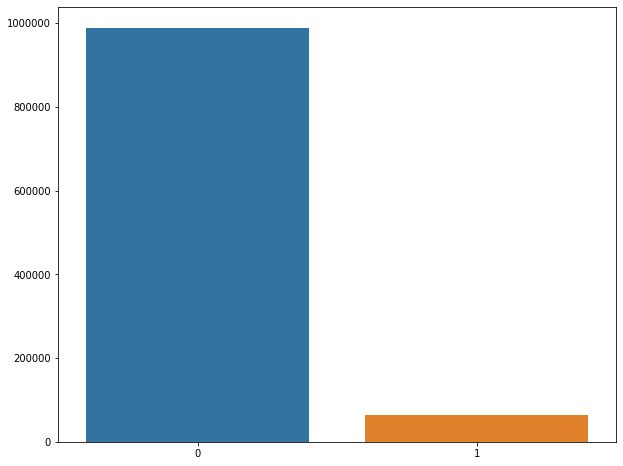

In [17]:
plt.figure(figsize=(10, 8))
sns.barplot(x=data_offline[data_offline.label != -1]['label'].value_counts().index,y=data_offline[data_offline.label != -1]['label'].value_counts().values)


In [18]:
# feature 表示正样本和负样本对应的数据集，取的是20190516号之前的数据集合，负样本将20190516号及之后的数据去除是为了防止未满15天带来的干扰
feature = data_offline[(data_offline['Date'] < '20160516') | ((data_offline['Date'] == 'null') & (data_offline['Date_received'] < '20160516'))].copy()
dataset = data_offline[(data_offline['Date_received'] >= '20160516') & (data_offline['Date_received'] <= '20160615')].copy()


In [19]:
# 用户聚合特征
fdf = feature.copy()
# key of user
u = fdf[['User_id']].copy().drop_duplicates()
# u_coupon_count : num of coupon received by user
u1 = fdf[fdf['Date_received'] != 'null'][['User_id']].copy()
u1['u_coupon_count'] = 1
u1 = u1.groupby(['User_id'], as_index = False).count()
# u_buy_count : times of user buy offline (with or without coupon)
u2 = fdf[fdf['Date'] != 'null'][['User_id']].copy()
u2['u_buy_count'] = 1
u2 = u2.groupby(['User_id'], as_index = False).count()
# u_buy_with_coupon : times of user buy offline (with coupon)
u3 = fdf[((fdf['Date'] != 'null') & (fdf['Date_received'] != 'null'))][['User_id']].copy()
u3['u_buy_with_coupon'] = 1
u3 = u3.groupby(['User_id'], as_index = False).count()
# u_merchant_count : num of merchant user bought from
u4 = fdf[fdf['Date'] != 'null'][['User_id', 'Merchant_id']].copy()
u4.drop_duplicates(inplace = True)
u4 = u4.groupby(['User_id'], as_index = False).count()
u4.rename(columns = {'Merchant_id':'u_merchant_count'}, inplace = True)
# u_min_distance，u_max_distance，u_mean_distance，u_median_distance
utmp = fdf[(fdf['Date'] != 'null') & (fdf['Date_received'] != 'null')][['User_id', 'distance']].copy()
utmp.replace(-1, np.nan, inplace = True)
u5 = utmp.groupby(['User_id'], as_index = False).min()
u5.rename(columns = {'distance':'u_min_distance'}, inplace = True)
u6 = utmp.groupby(['User_id'], as_index = False).max()
u6.rename(columns = {'distance':'u_max_distance'}, inplace = True)
u7 = utmp.groupby(['User_id'], as_index = False).mean()
u7.rename(columns = {'distance':'u_mean_distance'}, inplace = True)
u8 = utmp.groupby(['User_id'], as_index = False).median()
u8.rename(columns = {'distance':'u_median_distance'}, inplace = True)
# merge all the features on key User_id
user_feature = pd.merge(u, u1, on = 'User_id', how = 'left')
user_feature = pd.merge(user_feature, u2, on = 'User_id', how = 'left')
user_feature = pd.merge(user_feature, u3, on = 'User_id', how = 'left')
user_feature = pd.merge(user_feature, u4, on = 'User_id', how = 'left')
user_feature = pd.merge(user_feature, u5, on = 'User_id', how = 'left')
user_feature = pd.merge(user_feature, u6, on = 'User_id', how = 'left')
user_feature = pd.merge(user_feature, u7, on = 'User_id', how = 'left')
user_feature = pd.merge(user_feature, u8, on = 'User_id', how = 'left')
# calculate rate
user_feature['u_use_coupon_rate'] = user_feature['u_buy_with_coupon'].astype('float')/user_feature['u_coupon_count'].astype('float')
user_feature['u_buy_with_coupon_rate'] = user_feature['u_buy_with_coupon'].astype('float')/user_feature['u_buy_count'].astype('float')
user_feature = user_feature.fillna(0)
# add user feature to dataset on key User_id
dataset2 = pd.merge(dataset, user_feature, on = 'User_id', how = 'left').fillna(0)



In [22]:
del u, u1, u2, u3, u4, u5, u6, u7, u8, utmp, user_feature
gc.collect()



200

In [23]:
# 商户聚合特征
# key of merchant
m = fdf[['Merchant_id']].copy().drop_duplicates()
# m_coupon_count : num of coupon from merchant
m1 = fdf[fdf['Date_received'] != 'null'][['Merchant_id']].copy()
m1['m_coupon_count'] = 1
m1 = m1.groupby(['Merchant_id'], as_index = False).count()
# m_sale_count : num of sale from merchant (with or without coupon)
m2 = fdf[fdf['Date'] != 'null'][['Merchant_id']].copy()
m2['m_sale_count'] = 1
m2 = m2.groupby(['Merchant_id'], as_index = False).count()
# m_sale_with_coupon : num of sale from merchant with coupon usage
m3 = fdf[(fdf['Date'] != 'null') & (fdf['Date_received'] != 'null')][['Merchant_id']].copy()
m3['m_sale_with_coupon'] = 1
m3 = m3.groupby(['Merchant_id'], as_index = False).count()
# m_min_distance，m_max_distance，m_mean_distance，m_median_distance
mtmp = fdf[(fdf['Date'] != 'null') & (fdf['Date_received'] != 'null')][['Merchant_id', 'distance']].copy()
mtmp.replace(-1, np.nan, inplace = True)
m4 = mtmp.groupby(['Merchant_id'], as_index = False).min()
m4.rename(columns = {'distance':'m_min_distance'}, inplace = True)
m5 = mtmp.groupby(['Merchant_id'], as_index = False).max()
m5.rename(columns = {'distance':'m_max_distance'}, inplace = True)
m6 = mtmp.groupby(['Merchant_id'], as_index = False).mean()
m6.rename(columns = {'distance':'m_mean_distance'}, inplace = True)
m7 = mtmp.groupby(['Merchant_id'], as_index = False).median()
m7.rename(columns = {'distance':'m_median_distance'}, inplace = True)
merchant_feature = pd.merge(m, m1, on = 'Merchant_id', how = 'left')
merchant_feature = pd.merge(merchant_feature, m2, on = 'Merchant_id', how = 'left')
merchant_feature = pd.merge(merchant_feature, m3, on = 'Merchant_id', how = 'left')
merchant_feature = pd.merge(merchant_feature, m4, on = 'Merchant_id', how = 'left')
merchant_feature = pd.merge(merchant_feature, m5, on = 'Merchant_id', how = 'left')
merchant_feature = pd.merge(merchant_feature, m6, on = 'Merchant_id', how = 'left')
merchant_feature = pd.merge(merchant_feature, m7, on = 'Merchant_id', how = 'left')
merchant_feature = merchant_feature.fillna(0)
merchant_feature['m_coupon_use_rate'] = merchant_feature['m_sale_with_coupon'].astype('float')/merchant_feature['m_coupon_count'].astype('float')
merchant_feature['m_sale_with_coupon_rate'] = merchant_feature['m_sale_with_coupon'].astype('float')/merchant_feature['m_sale_count'].astype('float')
merchant_feature = merchant_feature.fillna(0)
# add merchant feature to dataset2
dataset3 = pd.merge(dataset2, merchant_feature, on = 'Merchant_id', how = 'left').fillna(0)


In [25]:
del m, m1, m2, m3, m4, m5, m6, m7, mtmp, merchant_feature
gc.collect()

285

In [26]:
# 用户&商户聚合特征
# key of user and merchant
um = fdf[['User_id', 'Merchant_id']].copy().drop_duplicates()
um1 = fdf[['User_id', 'Merchant_id']].copy()
um1['um_count'] = 1
um1 = um1.groupby(['User_id', 'Merchant_id'], as_index = False).count()
um2 = fdf[fdf['Date'] != 'null'][['User_id', 'Merchant_id']].copy()
um2['um_buy_count'] = 1
um2 = um2.groupby(['User_id', 'Merchant_id'], as_index = False).count()
um3 = fdf[fdf['Date_received'] != 'null'][['User_id', 'Merchant_id']].copy()
um3['um_coupon_count'] = 1
um3 = um3.groupby(['User_id', 'Merchant_id'], as_index = False).count()
um4 = fdf[(fdf['Date_received'] != 'null') & (fdf['Date'] != 'null')][['User_id', 'Merchant_id']].copy()
um4['um_buy_with_coupon'] = 1
um4 = um4.groupby(['User_id', 'Merchant_id'], as_index = False).count()
# merge all user merchant
user_merchant_feature = pd.merge(um, um1, on = ['User_id','Merchant_id'], how = 'left')
user_merchant_feature = pd.merge(user_merchant_feature, um2, on = ['User_id','Merchant_id'], how = 'left')
user_merchant_feature = pd.merge(user_merchant_feature, um3, on = ['User_id','Merchant_id'], how = 'left')
user_merchant_feature = pd.merge(user_merchant_feature, um4, on = ['User_id','Merchant_id'], how = 'left')
user_merchant_feature = user_merchant_feature.fillna(0)
user_merchant_feature['um_buy_rate'] = user_merchant_feature['um_buy_count'].astype('float')/user_merchant_feature['um_count'].astype('float')
user_merchant_feature['um_coupon_use_rate'] = user_merchant_feature['um_buy_with_coupon'].astype('float')/user_merchant_feature['um_coupon_count'].astype('float')
user_merchant_feature['um_buy_with_coupon_rate'] = user_merchant_feature['um_buy_with_coupon'].astype('float')/user_merchant_feature['um_buy_count'].astype('float')
user_merchant_feature = user_merchant_feature.fillna(0)
# add user_merchant_feature to data3
dataset4 = pd.merge(dataset3, user_merchant_feature, on = ['User_id','Merchant_id'], how = 'left').fillna(0)


In [28]:
del um, um1, um2, um3, um4, user_merchant_feature
gc.collect()

215

In [29]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2
    for col in tqdm(df.columns):
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

dataset4 = reduce_mem_usage(dataset4)

100%|██████████| 42/42 [00:00<00:00, 96.98it/s]

Mem. usage decreased to 26.37 Mb (67.7% reduction)


In [30]:
# 定义sparse feature和dense feature
sparse_features = ['User_id', 'Merchant_id', 'Coupon_id', 'weekday', 'discount_type', 'weekday_type']
dense_features = [fea for fea in dataset4.columns if fea not in sparse_features and fea not in ['Discount_rate', 'Distance', 'Date_received', 'Date', 'label']]


In [48]:
dataset4[sparse_features][:10]

,User_id,Merchant_id,Coupon_id,weekday,discount_type,weekday_type
0,1439408,4663,11000.0,6,1,1
1,1439408,2632,8592.0,1,1,0
2,1439408,2632,8592.0,1,1,0
3,2029232,450,1532.0,1,1,0
4,2029232,6459,12736.0,4,1,0
5,2747744,6901,1097.0,1,1,0
6,196342,1579,10696.0,1,1,0
7,253750,6901,2366.0,3,1,0
8,343660,4663,11000.0,6,1,1
9,1113008,3621,2704.0,2,1,0


In [49]:
dataset4[dense_features][:10]

,discount_rate,discount_man,discount_jian,distance,day,u_coupon_count,u_buy_count,u_buy_with_coupon,u_merchant_count,u_min_distance,u_max_distance,u_mean_distance,u_median_distance,u_use_coupon_rate,u_buy_with_coupon_rate,m_coupon_count,m_sale_count,m_sale_with_coupon,m_min_distance,m_max_distance,m_mean_distance,m_median_distance,m_coupon_use_rate,m_sale_with_coupon_rate,um_count,um_buy_count,um_coupon_count,um_buy_with_coupon,um_buy_rate,um_coupon_use_rate,um_buy_with_coupon_rate
0,0.866699,150,20,1,28,2.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,4360.0,1296.0,45.0,0.0,10.0,2.146484,0.0,0.010323,0.034729,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
1,0.950195,20,1,0,13,2.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,35.0,18.0,3.0,1.0,1.0,1.000000,1.0,0.085693,0.166626,3.0,1.0,2.0,0.0,0.333252,0.0,0.0
2,0.950195,20,1,0,16,2.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,35.0,18.0,3.0,1.0,1.0,1.000000,1.0,0.085693,0.166626,3.0,1.0,2.0,0.0,0.333252,0.0,0.0
3,0.833496,30,5,0,30,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,42944.0,8576.0,679.0,0.0,10.0,0.862305,0.0,0.015808,0.079163,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
4,0.950195,20,1,0,19,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
5,0.799805,50,10,-1,6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4704.0,9040.0,407.0,0.0,10.0,0.450195,0.0,0.086487,0.045013,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
6,0.950195,20,1,1,6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,27.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
7,0.833496,30,5,0,18,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,4704.0,9040.0,407.0,0.0,10.0,0.450195,0.0,0.086487,0.045013,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
8,0.866699,150,20,-1,28,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4360.0,1296.0,45.0,0.0,10.0,2.146484,0.0,0.010323,0.034729,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
9,0.750000,20,5,0,24,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,3348.0,3964.0,272.0,0.0,10.0,0.564941,0.0,0.081238,0.068665,0.0,0.0,0.0,0.0,0.000000,0.0,0.0


In [50]:
dataset4[sparse_features] = dataset4[sparse_features].fillna('null', )
dataset4[dense_features] = dataset4[dense_features].fillna(0, )

In [51]:
log_features = ['u_coupon_count', 'u_buy_count','u_buy_with_coupon', 'u_merchant_count', 'u_min_distance',
       'u_max_distance', 'u_mean_distance', 'u_median_distance',
       'u_use_coupon_rate', 'u_buy_with_coupon_rate', 'm_coupon_count',
       'm_sale_count', 'm_sale_with_coupon', 'm_min_distance',
       'm_max_distance', 'm_mean_distance', 'm_median_distance',
       'm_coupon_use_rate', 'm_sale_with_coupon_rate', 'um_count',
       'um_buy_count', 'um_coupon_count', 'um_buy_with_coupon', 'um_buy_rate',
       'um_coupon_use_rate', 'um_buy_with_coupon_rate']

In [52]:
dataset4[log_features][:10]

,u_coupon_count,u_buy_count,u_buy_with_coupon,u_merchant_count,u_min_distance,u_max_distance,u_mean_distance,u_median_distance,u_use_coupon_rate,u_buy_with_coupon_rate,m_coupon_count,m_sale_count,m_sale_with_coupon,m_min_distance,m_max_distance,m_mean_distance,m_median_distance,m_coupon_use_rate,m_sale_with_coupon_rate,um_count,um_buy_count,um_coupon_count,um_buy_with_coupon,um_buy_rate,um_coupon_use_rate,um_buy_with_coupon_rate
0,2.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,4360.0,1296.0,45.0,0.0,10.0,2.146484,0.0,0.010323,0.034729,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
1,2.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,35.0,18.0,3.0,1.0,1.0,1.000000,1.0,0.085693,0.166626,3.0,1.0,2.0,0.0,0.333252,0.0,0.0
2,2.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,35.0,18.0,3.0,1.0,1.0,1.000000,1.0,0.085693,0.166626,3.0,1.0,2.0,0.0,0.333252,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,42944.0,8576.0,679.0,0.0,10.0,0.862305,0.0,0.015808,0.079163,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4704.0,9040.0,407.0,0.0,10.0,0.450195,0.0,0.086487,0.045013,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,27.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
7,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,4704.0,9040.0,407.0,0.0,10.0,0.450195,0.0,0.086487,0.045013,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4360.0,1296.0,45.0,0.0,10.0,2.146484,0.0,0.010323,0.034729,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
9,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,3348.0,3964.0,272.0,0.0,10.0,0.564941,0.0,0.081238,0.068665,0.0,0.0,0.0,0.0,0.000000,0.0,0.0


In [53]:
for fea in tqdm(log_features):
    dataset4[fea] = dataset4[fea].apply(lambda x: np.log1p(x))

100%|██████████| 26/26 [00:07<00:00,  3.71it/s]


In [54]:
dataset4[log_features][:10]

,u_coupon_count,u_buy_count,u_buy_with_coupon,u_merchant_count,u_min_distance,u_max_distance,u_mean_distance,u_median_distance,u_use_coupon_rate,u_buy_with_coupon_rate,m_coupon_count,m_sale_count,m_sale_with_coupon,m_min_distance,m_max_distance,m_mean_distance,m_median_distance,m_coupon_use_rate,m_sale_with_coupon_rate,um_count,um_buy_count,um_coupon_count,um_buy_with_coupon,um_buy_rate,um_coupon_use_rate,um_buy_with_coupon_rate
0,1.098612,0.693147,0.0,0.693147,0.0,0.0,0.0,0.0,0.0,0.0,8.380457,7.167809,3.828641,0.000000,2.397895,1.146286,0.000000,0.010270,0.034140,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0
1,1.098612,0.693147,0.0,0.693147,0.0,0.0,0.0,0.0,0.0,0.0,3.583519,2.944439,1.386294,0.693147,0.693147,0.693147,0.693147,0.082219,0.154116,1.386294,0.693147,1.098612,0.0,0.287621,0.0,0.0
2,1.098612,0.693147,0.0,0.693147,0.0,0.0,0.0,0.0,0.0,0.0,3.583519,2.944439,1.386294,0.693147,0.693147,0.693147,0.693147,0.082219,0.154116,1.386294,0.693147,1.098612,0.0,0.287621,0.0,0.0
3,0.693147,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,10.667676,9.056839,6.522093,0.000000,2.397895,0.621815,0.000000,0.015684,0.076185,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0
4,0.693147,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1.791759,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0
5,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,8.456381,9.109525,6.011267,0.000000,2.397895,0.371698,0.000000,0.082949,0.044030,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0
6,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,1.386294,3.332205,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0
7,0.693147,0.693147,0.0,0.693147,0.0,0.0,0.0,0.0,0.0,0.0,8.456381,9.109525,6.011267,0.000000,2.397895,0.371698,0.000000,0.082949,0.044030,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0
8,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,8.380457,7.167809,3.828641,0.000000,2.397895,1.146286,0.000000,0.010270,0.034140,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0
9,0.693147,0.693147,0.0,0.693147,0.0,0.0,0.0,0.0,0.0,0.0,8.116417,8.285261,5.609472,0.000000,2.397895,0.447848,0.000000,0.078106,0.066410,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0


In [55]:
for feat in tqdm(sparse_features):
    lbe = LabelEncoder()
    dataset4[feat] = lbe.fit_transform(dataset4[feat])

100%|██████████| 6/6 [00:00<00:00, 71.56it/s]


In [56]:
dataset4[sparse_features][:10]

,User_id,Merchant_id,Coupon_id,weekday,discount_type,weekday_type
0,33371,2219,2779,5,1,1
1,33371,1263,2481,0,1,0
2,33371,1263,2481,0,1,0
3,46986,217,669,0,1,0
4,46986,3076,2994,3,1,0
5,63611,3302,472,0,1,0
6,4428,764,2742,0,1,0
7,5795,3302,967,2,1,0
8,7896,2219,2779,5,1,1
9,25681,1728,1060,1,1,0


In [57]:
mms = MinMaxScaler(feature_range=(0, 1))
dataset4[dense_features] = mms.fit_transform(dataset4[dense_features])

In [58]:
dataset4[dense_features][:10]

,discount_rate,discount_man,discount_jian,distance,day,u_coupon_count,u_buy_count,u_buy_with_coupon,u_merchant_count,u_min_distance,u_max_distance,u_mean_distance,u_median_distance,u_use_coupon_rate,u_buy_with_coupon_rate,m_coupon_count,m_sale_count,m_sale_with_coupon,m_min_distance,m_max_distance,m_mean_distance,m_median_distance,m_coupon_use_rate,m_sale_with_coupon_rate,um_count,um_buy_count,um_coupon_count,um_buy_with_coupon,um_buy_rate,um_coupon_use_rate,um_buy_with_coupon_rate
0,0.811966,0.500000,0.20,0.181818,0.900000,0.241810,0.136078,0.0,0.289065,0.0,0.0,0.0,0.0,0.0,0.0,0.785594,0.737312,0.491516,0.000000,1.000000,0.478038,0.000000,0.014816,0.049253,0.00000,0.000000,0.00000,0.0,0.000000,0.0,0.0
1,0.939056,0.066667,0.01,0.090909,0.400000,0.241810,0.136078,0.0,0.289065,0.0,0.0,0.0,0.0,0.0,0.0,0.335923,0.302878,0.177971,0.289065,0.289065,0.289065,0.289065,0.118617,0.222342,0.30103,0.151178,0.24296,0.0,0.414949,0.0,0.0
2,0.939056,0.066667,0.01,0.090909,0.500000,0.241810,0.136078,0.0,0.289065,0.0,0.0,0.0,0.0,0.0,0.0,0.335923,0.302878,0.177971,0.289065,0.289065,0.289065,0.289065,0.118617,0.222342,0.30103,0.151178,0.24296,0.0,0.414949,0.0,0.0
3,0.761427,0.100000,0.05,0.090909,0.966667,0.152565,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.931625,0.837298,0.000000,1.000000,0.259317,0.000000,0.022628,0.109912,0.00000,0.000000,0.00000,0.0,0.000000,0.0,0.0
4,0.939056,0.066667,0.01,0.090909,0.600000,0.152565,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.184308,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,0.0,0.000000,0.0,0.0
5,0.710145,0.166667,0.10,0.000000,0.166667,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.792711,0.937045,0.771719,0.000000,1.000000,0.155010,0.000000,0.119671,0.063521,0.00000,0.000000,0.00000,0.0,0.000000,0.0,0.0
6,0.939056,0.066667,0.01,0.181818,0.166667,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.129953,0.342765,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,0.0,0.000000,0.0,0.0
7,0.761427,0.100000,0.05,0.090909,0.566667,0.152565,0.136078,0.0,0.289065,0.0,0.0,0.0,0.0,0.0,0.0,0.792711,0.937045,0.771719,0.000000,1.000000,0.155010,0.000000,0.119671,0.063521,0.00000,0.000000,0.00000,0.0,0.000000,0.0,0.0
8,0.811966,0.500000,0.20,0.000000,0.900000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.785594,0.737312,0.491516,0.000000,1.000000,0.478038,0.000000,0.014816,0.049253,0.00000,0.000000,0.00000,0.0,0.000000,0.0,0.0
9,0.634337,0.066667,0.05,0.090909,0.766667,0.152565,0.136078,0.0,0.289065,0.0,0.0,0.0,0.0,0.0,0.0,0.760842,0.852258,0.720137,0.000000,1.000000,0.186767,0.000000,0.112684,0.095809,0.00000,0.000000,0.00000,0.0,0.000000,0.0,0.0


In [62]:
from collections import OrderedDict, namedtuple

class SingleFeat(namedtuple('SingleFeat', ['name', 'dimension', 'dtype'])):
    __slots__ = ()

    def __new__(cls, name, dimension, dtype="float32"):
        return super(SingleFeat, cls).__new__(cls, name, dimension, dtype)
sparse_feature_list = [SingleFeat(feat, dataset4[feat].nunique()) for feat in sparse_features]

In [67]:
sparse_feature_list

[SingleFeat(name='User_id', dimension=170233, dtype='float32'),
 SingleFeat(name='Merchant_id', dimension=4240, dtype='float32'),
 SingleFeat(name='Coupon_id', dimension=3156, dtype='float32'),
 SingleFeat(name='weekday', dimension=7, dtype='float32'),
 SingleFeat(name='discount_type', dimension=2, dtype='float32'),
 SingleFeat(name='weekday_type', dimension=2, dtype='float32')]

In [68]:
dense_feature_list = [SingleFeat(feat, 0,) for feat in dense_features]

In [69]:
dense_feature_list

[SingleFeat(name='discount_rate', dimension=0, dtype='float32'),
 SingleFeat(name='discount_man', dimension=0, dtype='float32'),
 SingleFeat(name='discount_jian', dimension=0, dtype='float32'),
 SingleFeat(name='distance', dimension=0, dtype='float32'),
 SingleFeat(name='day', dimension=0, dtype='float32'),
 SingleFeat(name='u_coupon_count', dimension=0, dtype='float32'),
 SingleFeat(name='u_buy_count', dimension=0, dtype='float32'),
 SingleFeat(name='u_buy_with_coupon', dimension=0, dtype='float32'),
 SingleFeat(name='u_merchant_count', dimension=0, dtype='float32'),
 SingleFeat(name='u_min_distance', dimension=0, dtype='float32'),
 SingleFeat(name='u_max_distance', dimension=0, dtype='float32'),
 SingleFeat(name='u_mean_distance', dimension=0, dtype='float32'),
 SingleFeat(name='u_median_distance', dimension=0, dtype='float32'),
 SingleFeat(name='u_use_coupon_rate', dimension=0, dtype='float32'),
 SingleFeat(name='u_buy_with_coupon_rate', dimension=0, dtype='float32'),
 SingleFeat(na

In [70]:
train, valid = train_test_split(dataset4, test_size=0.2, stratify=dataset4['label'], random_state=2019)


In [72]:
train_model_input = [train[feat.name].values for feat in sparse_feature_list] + \
                    [train[feat.name].values for feat in dense_feature_list]

In [81]:
valid_model_input = [valid[feat.name].values for feat in sparse_feature_list] + \
                   [valid[feat.name].values for feat in dense_feature_list]

In [82]:
checkpoint_predictions = []
weights = []